In [2]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import logging

In [ ]:

pickle_path = '../recorded-data/train/135968/snapshot.pickle'
with open(pickle_path, 'rb') as data:
        content = pickle.load(data)
        print(int(len(content.keys()) / 4))

In [24]:
import pickle
import coloredlogs, logging
import os

from torch.utils.data import Dataset
coloredlogs.install()

class IndexDataset:

    def __init__(self, dir_path):        
        self.root_path = dir_path
        self.pickle_path = os.path.join(dir_path , 'snapshot.pickle')        
        
        logging.info('Parsing pickle file...')
    
        with open(self.pickle_path, 'rb') as data:
            self.content = pickle.load(data)

        logging.info('Picklefile loaded')

        # Exclude keys that does not have a local goal [as the robot did not travel 10 meters]
        keys = list(self.content.keys())
        for key in keys:
            if 'local_goal' not in self.content[key].keys():
                self.content.pop(key)

    def __len__(self):
        # Excluding last 2 minutes of recording may not have local_goal
        # Snapshot is taken at 2 frames per second

        return int(len(self.content.keys()) / 4)
    
    def __getitem__(self, offset_index) :
        # We are taking 4 sequential images, point clouds each time to account for temporal variation
        start_index = offset_index * 4
        end_index = start_index + 3

        # Get data from respective index
        prev_cmd_vel = self.content[end_index]['prev_cmd_vel']
        gt_cmd_vel = self.content[end_index]['gt_cmd_vel']
        local_goal = self.content[end_index]['local_goal']
        robot_position = self.content[end_index]['robot_position']
        
        # Image paths
        image_paths = [ os.path.join(self.root_path, str(i)+'.jpg') for i in range(start_index, end_index+1) ]
        
        # only keep points that are under 5 + 1 (delta) meters from the robot
        point_clouds = []
        total_length = 0
        for point_snapshot in range(start_index, end_index+1):
            filtered_points = []
            for point in self.content[point_snapshot]['point_cloud']:
                if (point[0]**2 + point[1]**2 + point[2]**2) <= 26:
                    filtered_points.append(point)
            print("from indexer:",len(filtered_points))                                        
            point_clouds.append(filtered_points[:7000])        

        return (image_paths, point_clouds, local_goal, prev_cmd_vel, robot_position, gt_cmd_vel)

        

indexer = IndexDataset('/Users/bhabaranjanpanigrahi/Research/Code/fusion-network/recorded-data/136021.bag')
# print(object.__len__())

2023-04-30 17:37:07 BhabaranjansMBP.eduroam.gmu.edu root[34997] INFO Parsing pickle file...
2023-04-30 17:37:26 BhabaranjansMBP.eduroam.gmu.edu root[34997] INFO Picklefile loaded


In [26]:
import torch
from torchvision import transforms
import pickle
import numpy as np
import coloredlogs, logging
import os
import cv2

from torch.utils.data import Dataset
from scipy.spatial.transform import Rotation as R

coloredlogs.install()

def read_images(path):
    # print(f"{path = }")
    image = cv2.imread(path)
    # Will have to do some re-sizing
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def get_transformation_matrix(position, quaternion):
    theta = R.from_quat([quaternion.x, quaternion.y, quaternion.z, quaternion.w]).as_euler('XYZ')[2]
    robo_coordinate_in_glob_frame  = np.array([[np.cos(theta), -np.sin(theta), position.x],
                    [np.sin(theta), np.cos(theta), position.y],
                    [0, 0, 1]])
    return robo_coordinate_in_glob_frame

def cart2polar(xyz):
    r = np.sqrt(xyz[:, 0] ** 2 + xyz[:, 1] ** 2)
    theta =  np.arctan2(xyz[:, 1], xyz[:, 0])
    return np.stack((r,theta, xyz[:,2]), axis=1)


class ApplyTransformation(Dataset):
    def __init__(self, input_data, grid_size = [72, 30, 30]):
        self.grid_size = np.asarray(grid_size)  
        self.input_data = input_data    
        self.image_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((224,224),antialias=True),
                    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean hardcoded
                    #                       std=[0.229, 0.224, 0.225])  # ImageNet std hardcoded
            ])
    
    def __len__(self):
         # TODO: this will return 1 example set with the following details
        return len(self.input_data)

    def __getitem__(self, index):
        # Transform images
        data = self.input_data[index]
        self.image_paths = data[0]
        self.point_clouds = data[1]
        self.local_goal = data[2]
        self.prev_cmd_vel = data[3]        
        self.robot_position  = data[4]
        self.gt_cmd_vel = data[5]
        

        images = [ self.image_transforms(read_images(path)) for path in self.image_paths]
        stacked_images = torch.cat(images, dim=0)
        
        # Transform local goal into robot frame
        robot_coordinate_in_glob_frame = get_transformation_matrix(self.robot_position[0],self.robot_position[1])
        transform_to_robot_coordinate =   np.linalg.pinv(robot_coordinate_in_glob_frame)

        local_goal_in_robot_frame = transform_to_robot_coordinate @ np.asanyarray([self.local_goal[0], self.local_goal[1],1]).reshape((3,1))	
        local_goal = (local_goal_in_robot_frame[0,0], local_goal_in_robot_frame[1,0])

        # Transform point-clouds to 3D-Cylider co-ordinate system
        point_clouds = np.concatenate(self.point_clouds, axis=0)   

        # TODO: subsample the point clouds to keep a fixed number of points across frames
        xyz_polar = cart2polar(point_clouds)

        max_bound_r = np.percentile(xyz_polar[:, 0], 100, axis=0)
        min_bound_r = np.percentile(xyz_polar[:, 0], 0, axis=0)

        max_bound = np.max(xyz_polar[:, 1:], axis=0)
        min_bound = np.min(xyz_polar[:, 1:], axis=0)

        max_bound = np.concatenate(([max_bound_r],max_bound))
        min_bound = np.concatenate(([min_bound_r], min_bound))

        range_to_crop = max_bound - min_bound
        cur_grid_size = (self.grid_size - 1)
        intervals = range_to_crop / cur_grid_size

        if (intervals == 0).any(): print("Zero interval!")
        grid_index = (np.floor(( np.clip(xyz_polar, min_bound, max_bound) - min_bound) / intervals)).astype(int)
        
        # Center data around each voxel for PTnet
        voxel_centers = (grid_index.astype(np.float32) + 0.5) * intervals + min_bound
        return_xyz = xyz_polar - voxel_centers
        transformed_pcl = np.concatenate((return_xyz, xyz_polar, point_clouds[:, :2]), axis=1)

         

        local_goal = torch.tensor(local_goal, dtype=torch.float32).ravel()
        local_goal = (local_goal - local_goal.min()) / (local_goal.max() - local_goal.min())

        prev_cmd_vel = torch.tensor(self.prev_cmd_vel, dtype=torch.float32).ravel()
        gt_cmd_vel = torch.tensor(self.gt_cmd_vel, dtype=torch.float32).ravel()


        return (stacked_images, torch.tensor(grid_index), torch.tensor(transformed_pcl), local_goal, prev_cmd_vel, gt_cmd_vel)

In [27]:
data = next(iter(ApplyTransformation(indexer)))
print(f"{data[2].shape = }")

from indexer: 7295
from indexer: 7188
from indexer: 7172
from indexer: 7614
called indxer 1
called indxer 2
called indxer 3
called indxer 4
called indxer 5
called indxer 6
data[2].shape = torch.Size([28000, 8])


In [90]:
x[2].shape

torch.Size([29269, 8])

In [38]:
y = x[1][1]
c = []
c.append(y)
c.append(y)
c.append(y)
d = torch.tensor(c)

In [39]:
d.shape

torch.Size([3, 29269, 8])

In [40]:
x = [torch.from_numpy(i) for i in c]

In [52]:
l = x[0]

In [56]:
l.shape

torch.Size([29269, 8])

In [51]:
import torch.nn.functional as F
d = np.ones((100,8))


In [57]:

k = F.pad(l, (1, 0), 'constant', value=7)

In [60]:
k[0]

tensor([ 7.0000e+00,  9.1713e-03,  8.8107e-03, -3.8865e-03,  3.0948e+00,
        -1.7204e+00, -8.2926e-01, -4.6118e-01, -3.0603e+00],
       dtype=torch.float64)

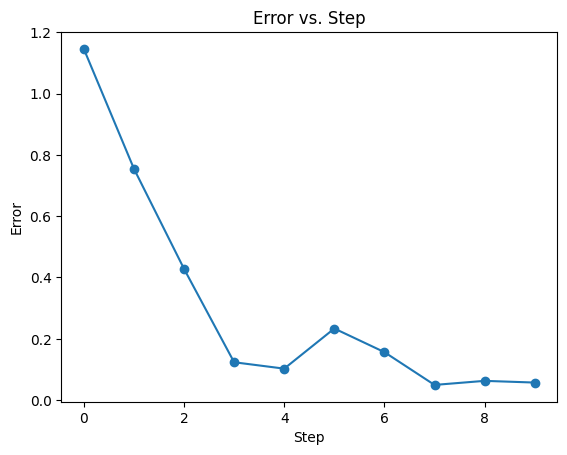

In [14]:
import matplotlib.pyplot as plt

# Create x and y data
x = [i for i in range(10)]
y = [1.1454883813858032, 0.7548354268074036, 0.42827606201171875, 0.12355022132396698, 0.10271172225475311, 0.23359526693820953, 0.15651413798332214, 0.049618806689977646, 0.06286948174238205, 0.057311490178108215]

# Plot the graph
plt.plot(x, y, '-o')
plt.xlabel('Step')
plt.ylabel('Error')
plt.title('Error vs. Step')
plt.show()